# REDES NEURONALES CONVOLUCIONALES
## Una Aplicación para Reconocimiento de Imágenes

---
Maestría en Inteligencia Artificial

UNIR Universidad Internacional de la Rioja en México

Asignatura: Sistemas Cognitivos Artificiales.

Actividad grupal desarrollada por Edmilson Prata da Silva, Mariana Carmona Cruz, Gerardo Davila escamilla y Pedro Luis Cabrera

---

## 💡 Introduccíon

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px">


## 📚 Librerias

Instalaciones y importaciones de librerias necesárias en el notebook.

In [1]:
# %pip install opencv-python numpy keras scikit-image

In [2]:
import cv2
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD,  RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Importaciones ok.")

Importaciones ok.


## ⚙️ Configuraciones

Configuraciones diversas para uso en el notebook.

In [3]:
# Configuración de la visualización de gráficos:
plt.rcParams["figure.figsize"] = (20, 6)

# La ruta raíz del conjunto de datos:
DATASET_PATH = "./datasets"

# Conjunto de datos de entrenamiento:
DATASET_TRAIN_PATH = "./datasets/simpsons_extracted/simpsons/train"

# Conjunto de datos de prueba:
DATASET_TEST_PATH = "./datasets/simpsons_extracted/simpsons/test"

# Definición de IMG_SIZE antes de que MAP_CHARACTERS se construya completamente:
IMG_SIZE = 100

# Epocas para el entrenamiento:
EPOCHS = 50

# Tamaño del lote para el entrenamiento:
BATCH_SIZE = 32

print("Configuraciones iniciales listas.")

Configuraciones iniciales listas.


## 📦 Carga de Datos

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

In [4]:
# Bajamos el dataset completo una única vez:
keras.utils.get_file(
    fname="simpsons.tar.gz",
    cache_dir="./",
    extract=True,
    origin="https://storage.googleapis.com/wandb-production.appspot.com/mlclass/simpsons.tar.gz"
)

'./datasets/simpsons_extracted'

### 🔍 Visualización del Dataset

Listagen de los archivos del dataset para verificación del correcto cargamento.

In [5]:
def list_files_recursively(startpath, show_files=False):
    for root, dirs, files in os.walk(startpath):
        
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/ {str(len(files)) + " archivos" if len(files) > 0 else ""}')

        if show_files:
            subindent = ' ' * 4 * (level + 1)
            for f in files:
                print(f'{subindent}{f}')
 
print(f"Lista de contenido de {DATASET_PATH}")
list_files_recursively(DATASET_PATH)

Lista de contenido de ./datasets
datasets/ 1 archivos
    simpsons_extracted/ 
        simpsons/ 
            test/ 
                charles_montgomery_burns/ 119 archivos
                chief_wiggum/ 98 archivos
                milhouse_van_houten/ 107 archivos
                sideshow_bob/ 87 archivos
                moe_szyslak/ 145 archivos
                ned_flanders/ 145 archivos
                abraham_grampa_simpson/ 91 archivos
                krusty_the_clown/ 120 archivos
                marge_simpson/ 129 archivos
                    .ipynb_checkpoints/ 3 archivos
                principal_skinner/ 119 archivos
                bart_simpson/ 134 archivos
                lisa_simpson/ 135 archivos
                homer_simpson/ 224 archivos
            train/ 
                charles_montgomery_burns/ 1074 archivos
                chief_wiggum/ 888 archivos
                milhouse_van_houten/ 972 archivos
                sideshow_bob/ 790 archivos
                moe_szysl

## 🛠️ Preprocesamiento

Preparación de los datos para el entrenamiento.

### 👥 Mapa de Caracteres

Creación dinámica de un mapa con los nombres de los personajes según los subdirectorios existentes en el dataset. La variable MAP_CHARACTERS contiene una asignación del número de clase al carácter. Solo incluirá los caracteres que tengan un directorio en el conjunto de entrenamiento.

In [6]:
MAP_CHARACTERS = {}

if os.path.exists(DATASET_TRAIN_PATH):
    character_names = sorted([d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))])
    for i, name in enumerate(character_names):
        MAP_CHARACTERS[i] = name
        
    print(f"{len(MAP_CHARACTERS)} caracteres cargados dinámicamente: {MAP_CHARACTERS}")

else:
    print(f"Error: No se encontró la ruta de entrenamiento {DATASET_TRAIN_PATH}. Asegúrese de que el conjunto de datos se extraiga correctamente.")

13 caracteres cargados dinámicamente: {0: 'abraham_grampa_simpson', 1: 'bart_simpson', 2: 'charles_montgomery_burns', 3: 'chief_wiggum', 4: 'homer_simpson', 5: 'krusty_the_clown', 6: 'lisa_simpson', 7: 'marge_simpson', 8: 'milhouse_van_houten', 9: 'moe_szyslak', 10: 'ned_flanders', 11: 'principal_skinner', 12: 'sideshow_bob'}


### 📥 Datos de Entrenamiento

Preparación de los datos de entrenamiento en imágenes. Como las imágenes tienen tamaños distintas, utilizamos la librería opencv para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """
    Carga los datos de entrenamiento en imágenes.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X_train: Array con todas las imágenes cargadas con tamaño IMG_SIZE x IMG_SIZE.
        y_train: Array con las labels de correspondientes a cada imagen.
    """
    X_train = []
    y_train = []

    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]

        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
       
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_train.append(image)
            y_train.append(label)

    return np.array(X_train), np.array(y_train)

### 📥 Datos de Prueba

Preparación de los datos de prueba en imágenes. Como las imágenes tienen tamaños distintas, utilizamos la librería opencv para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """
    Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test.
    """

    X_test = []
    y_test = []
   
    for label, character in map_characters.items():

        char_path = os.path.join(dirname, character)
        
        if os.path.exists(char_path):
            files = os.listdir(char_path)
            images = [file for file in files if file.endswith("jpg")]

            if verbose:
                print("Leyendo {} imágenes encontradas de {} para test".format(len(images), character))
            
            for image_name in images:
                image = cv2.imread(os.path.join(char_path, image_name))
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_test.append(image)
                y_test.append(label)

        elif verbose:
            print(f"Advertencia: Directorio de test para '{character}' no encontrado en {char_path}")
    
    print("Leídas {} imágenes de test en total".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


### ⚙️ Preparación de los Datos

Separación y preparación de los datos de entrenamiento y prueba lo que incluyé el ajuste de tamaño de las imagenes para IMG_SIZE x IMG_SIZE.

In [9]:
X_train_original, y_train_original = load_train_set(DATASET_TRAIN_PATH, MAP_CHARACTERS)
X_test_original, y_test_original = load_test_set(DATASET_TEST_PATH, MAP_CHARACTERS)

Leyendo 822 imágenes encontradas de abraham_grampa_simpson


Leyendo 1210 imágenes encontradas de bart_simpson
Leyendo 1074 imágenes encontradas de charles_montgomery_burns
Leyendo 888 imágenes encontradas de chief_wiggum
Leyendo 2022 imágenes encontradas de homer_simpson
Leyendo 1086 imágenes encontradas de krusty_the_clown
Leyendo 1219 imágenes encontradas de lisa_simpson
Leyendo 1162 imágenes encontradas de marge_simpson
Leyendo 972 imágenes encontradas de milhouse_van_houten
Leyendo 1307 imágenes encontradas de moe_szyslak
Leyendo 1309 imágenes encontradas de ned_flanders
Leyendo 1075 imágenes encontradas de principal_skinner
Leyendo 790 imágenes encontradas de sideshow_bob
Leyendo 91 imágenes encontradas de abraham_grampa_simpson para test
Leyendo 134 imágenes encontradas de bart_simpson para test
Leyendo 119 imágenes encontradas de charles_montgomery_burns para test
Leyendo 98 imágenes encontradas de chief_wiggum para test
Leyendo 224 imágenes encontradas de homer_simpson para test
Leyendo 120 imágenes encontradas de krusty_the_clown para 

### ⚙️ Barajando los Datos

Vamos a barajar los datos aleatoriamente. Esto es importante porque, si no lo hacemos y, por ejemplo, usamos el 20 % de los datos finales como conjunto de validación, solo usaremos una pequeña cantidad de caracteres, ya que las imágenes se leen secuencialmente para cada carácter.

In [10]:
perm_train = np.random.permutation(len(X_train_original))
X_train_original, y_train_original = X_train_original[perm_train], y_train_original[perm_train]

perm_test = np.random.permutation(len(X_test_original))
X_test_original, y_test_original = X_test_original[perm_test], y_test_original[perm_test]

print("Datos barajados.")

Datos barajados.


Text(0.5, 1.0, 'Label: 8 - Character: milhouse_van_houten')

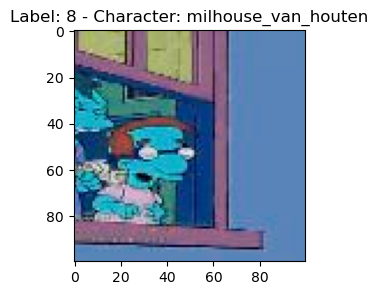

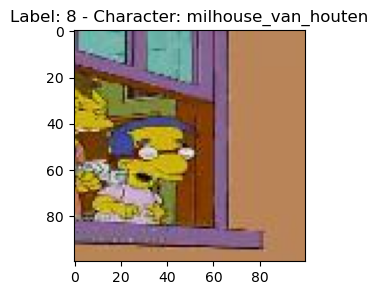

In [11]:
# Muestras de los datos de entrenamiento:
plt.figure(figsize=(3,3))
plt.imshow(X_train_original[2])
plt.title(f"Label: {y_train_original[2]} - Character: {MAP_CHARACTERS[y_train_original[2]]}")

# Muestra de la imagen invertida:
plt.figure(figsize=(3,3))
plt.imshow(np.flip(X_train_original[2], axis=-1) )
plt.title(f"Label: {y_train_original[2]} - Character: {MAP_CHARACTERS[y_train_original[2]]}")

### 🔬 Normalización de Datos

Las imágenes no están normalizadas. Hay que normalizarlas para obtener mejores resultados en el entrenamiento y en el clasificador (modelo final). La normalización ofrece ventajas como estabilidad numérica, comparación de coeficientes del modelo, evitación de distribuciones con un alto rango dinámico y estabilidad en el cálculo de variables.

In [12]:
X_train_std = X_train_original.astype('float32') / 255.0
X_test_std = X_test_original.astype('float32') / 255.0

print(f"Shape de X_train_original antes de la normalización: {X_train_original.shape}. Rango de valores: {X_train_original.min()} - {X_train_original.max()}")
print(f"Shape de X_test_original antes de la normalización: {X_test_original.shape}. Rango de valores: {X_test_original.min()} - {X_test_original.max()}")
print(f"Shape de X_train_std después de la normalización: {X_train_std.shape}. Rango de valores: {X_train_std.min()} - {X_train_std.max()}")
print(f"Shape de X_test_std después de la normalización: {X_test_std.shape}. Rango de valores: {X_test_std.min()} - {X_test_std.max()}")

Shape de X_train_original antes de la normalización: (14936, 100, 100, 3). Rango de valores: 0 - 255
Shape de X_test_original antes de la normalización: (1653, 100, 100, 3). Rango de valores: 0 - 255
Shape de X_train_std después de la normalización: (14936, 100, 100, 3). Rango de valores: 0.0 - 1.0
Shape de X_test_std después de la normalización: (1653, 100, 100, 3). Rango de valores: 0.0 - 1.0


### 🧪 One-Hot Encoding

La técnica One-hot Encoding es utilizada para convertir datos categóricos (como "rojo", "azul", "verde") a un formato numérico para el aprendizaje automático, creando nuevas columnas binarias (0 o 1) para cada categoría. Un "1" en una columna indica la presencia de esa categoría específica, mientras que un "0" significa su ausencia, lo que evita que los algoritmos asuman un orden o importancia falsos entre categorías. Es esencial para los modelos que requieren datos numéricos y gestiona eficazmente las características nominales (desordenadas), transformando una sola columna en múltiples columnas binarias.

Por qué se utiliza:
- Requisito del aprendizaje automático: Muchos algoritmos no pueden procesar texto/categorías directamente y necesitan números.
- Evita la ordinalidad: Evita que los modelos malinterpreten las categorías como si tuvieran un orden numérico (p. ej., "Azul" no es "menor que" "Verde").
- Representación única: Cada categoría tiene su propio vector numérico, lo que las hace semánticamente independientes.

In [13]:
num_classes = len(MAP_CHARACTERS)
y_train_ohe = to_categorical(y_train_original, num_classes)
y_test_ohe = to_categorical(y_test_original, num_classes)

print(f"Shape de y_train después de one-hot encoding: {y_train_ohe.shape}, Ejemplo: {y_train_ohe[0]}")
print(f"Shape de y_test después de one-hot encoding: {y_test_ohe.shape}, Ejemplo: {y_test_ohe[0]}")

Shape de y_train después de one-hot encoding: (14936, 13), Ejemplo: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape de y_test después de one-hot encoding: (1653, 13), Ejemplo: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### ⚙️ Separación de los Datos (Train/Validation)

Separación de los datos en dos conjuntos de datos: uno para el entrenamiento del algoritmo y otro para la validación del modelo. Los datos serán partidos en training/validation para tener una buena estimación de los valores que el modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Será utilizada una partición 80/20.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_std, y_train_ohe, test_size=0.2, random_state=42, stratify=y_train_ohe)

print(f"Shape de X_train: {X_train.shape}. Rango de valores: {X_train.min()} - {X_train.max()}")
print(f"Shape de y_train: {y_train.shape}. Rango de valores: {y_train.min()} - {y_train.max()}")
print(f"Shape de X_val: {X_val.shape}. Rango de valores: {X_val.min()} - {X_val.max()}")
print(f"Shape de y_val: {y_val.shape}. Rango de valores: {y_val.min()} - {y_val.max()}")

Shape de X_train: (11948, 100, 100, 3). Rango de valores: 0.0 - 1.0
Shape de y_train: (11948, 13). Rango de valores: 0.0 - 1.0
Shape de X_val: (2988, 100, 100, 3). Rango de valores: 0.0 - 1.0
Shape de y_val: (2988, 13). Rango de valores: 0.0 - 1.0


## 🧠 CNN - Convolutional Neural Networks con Keras

Utilizando CNN (Convolutional Neural Networks) con Keras, entrenaremos un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactaremos un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en el informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

**Notas:**
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### 🔬 CNN - Definición de la arquitectura

Definición de la arquitectura de la red neuronal CNN, compilación del modelo y resumen del modelo.

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,648,109 (10.10 MB)

 Trainable params: 2,648,109 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

### 🔍 CNN - Callbacks para Early Stopping

Definición de callbacks para guardar el mejor modelo y ejecutar una detención temprana (early stopping) al alcanzarlo. Esta técnica impide que el entrenamiento del modelo continúe incluso después de cumplirse los requisitos de calidad deseados, lo que consume más recursos y tiempo innecesariamente.

In [16]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
print("Callbacks definidos.")

Callbacks definidos.


### ⚙️ CNN - Entrenamiento del modelo

Entrenamiento del modelo con control de parada temprana, según todos los ajustes previamente configurados.

In [ ]:
history = model.fit(
    X_train, # Datos de entrenamiento
    y_train, # Labels de entrenamiento
    epochs=EPOCHS, # Número de épocas
    batch_size=BATCH_SIZE, # Tamaño del batch
    validation_data=(X_val, y_val), # Datos de validación
    callbacks=[checkpoint, early_stopping] # Callbacks para guardar el mejor modelo y detener el entrenamiento temprano
)

print("Entrenamiento completado.")

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.1825 - loss: 2.3895
Epoch 1: val_accuracy improved from None to 0.45850, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 175s 460ms/step - accuracy: 0.2564 - loss: 2.1981 - val_accuracy: 0.4585 - val_loss: 1.7123
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4346 - loss: 1.7088
Epoch 2: val_accuracy improved from 0.45850 to 0.56392, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 159s 426ms/step - accuracy: 0.4661 - loss: 1.6207 - val_accuracy: 0.5639 - val_loss: 1.4119
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5686 - loss: 1.3090
Epoch 3: val_accuracy improved from 0.56392 to 0.69244, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 138s 369ms/step - accuracy: 0.5964 - loss: 1.2488 - val_accuracy: 0.6924 - val_loss: 0.9323
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6706 - loss: 1.0211
Epoch 4: val_accuracy

### 📊 CNN - Evaluación del modelo

Evaluación del modelo entrenado en el conjunto de test.

#### 📌 CNN - Verificación de la Precisión (Red)

Para este trabajo, la precisión del modelo debe ser al menos del 85 %.

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8457 - loss: 0.7959
Accuracy en el conjunto de test: 84.57%


Text(0.5, 1.0, 'Curvas de Accuracy')

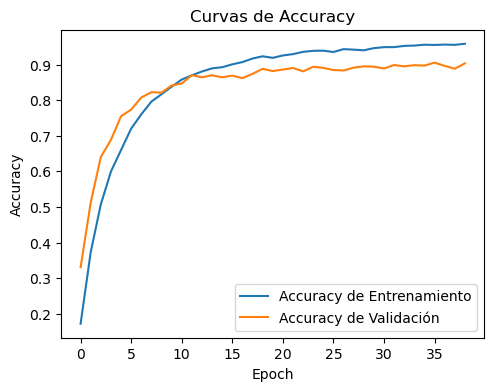

In [ ]:
loss, accuracy = model.evaluate(X_test_std, y_test_ohe, verbose=1)

print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de Accuracy')

👉 El modelo no alcanzó la precisión deseada del 85 %. Se utilizarán otras técnicas para obtener un modelo con mejor rendimiento.

#### 📌 CNN - Verificación de los Errores (Red)

Análisis visual de los errores de la red.

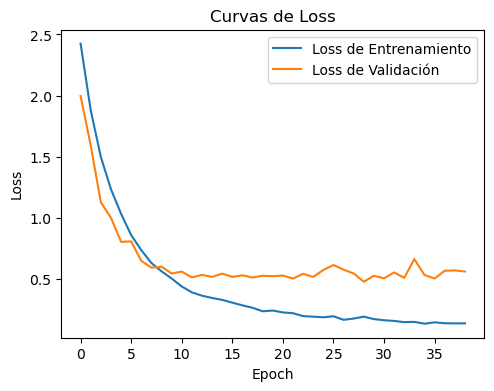

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de Loss')
plt.show()

#### 📌 CNN - Verificación de los Errores (Best Model)

Análisis de los errores del mejor modelo. Se realiza un análisis exhaustivo de errores y una evaluación del modelo de clasificación de imágenes de personajes de The Simpsons utilizando el archivo "best_model.keras". Este análisis incluye hacer predicciones sobre el conjunto de prueba (X_test, y_test), identificar imágenes mal clasificadas, generar un reporte de clasificación y una matriz de confusión. Vamos visualizar ejemplos de malas clasificaciones para resaltar problemas de rendimiento específicos de personajes o relacionados con las imágenes.

In [ ]:
# Carga del mejor modelo guardado durante el entrenamiento
loaded_model = load_model('best_model.keras')
print("Best model loaded successfully.")

# Evaluación del modelo cargado
loss, accuracy = loaded_model.evaluate(X_test_std, y_test_ohe, verbose=1)
print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")

Best model loaded successfully.
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8397 - loss: 0.8742
Accuracy en el conjunto de test: 83.97%


#### 📌 CNN Best Model - Predicciones

Ahora que el mejor modelo está cargado, haremos predicciones sobre el conjunto de prueba (X_test) utilizando el loaded_model. Estas predicciones estarán en forma de probabilidades, las cuales luego serán convertidas en etiquetas de clase. También convertiremos las etiquetas verdaderas (y_test) desde la codificación one-hot a etiquetas de clase para facilitar la comparación y la identificación de clasificaciones incorrectas.

In [ ]:
y_pred_probs = loaded_model.predict(X_test_std)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_ohe, axis=1)

print("Predicciones generadas y true labels convertidas a índices de clase.")

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step
Predicciones generadas y true labels convertidas a índices de clase.


#### 📌 CNN Best Model - Imágenes mal Clasificadas

Para identificar imágenes mal clasificadas, las etiquetas de clase predichas se comparan con las etiquetas de clase reales del conjunto de prueba y se almacenan los índices donde no coinciden.

In [ ]:
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
num_misclassified = len(misclassified_indices)
print(f"Número de imágenes mal clasificadas: {num_misclassified}")

Número de imágenes mal clasificadas: 265


#### 📌 CNN Best Model - Ejemplos de Imágenes mal Clasificadas

Ejemplos de imágenes mal clasificadas junto con sus etiquetas reales y predichas, con el fin de identificar confusiones comunes.

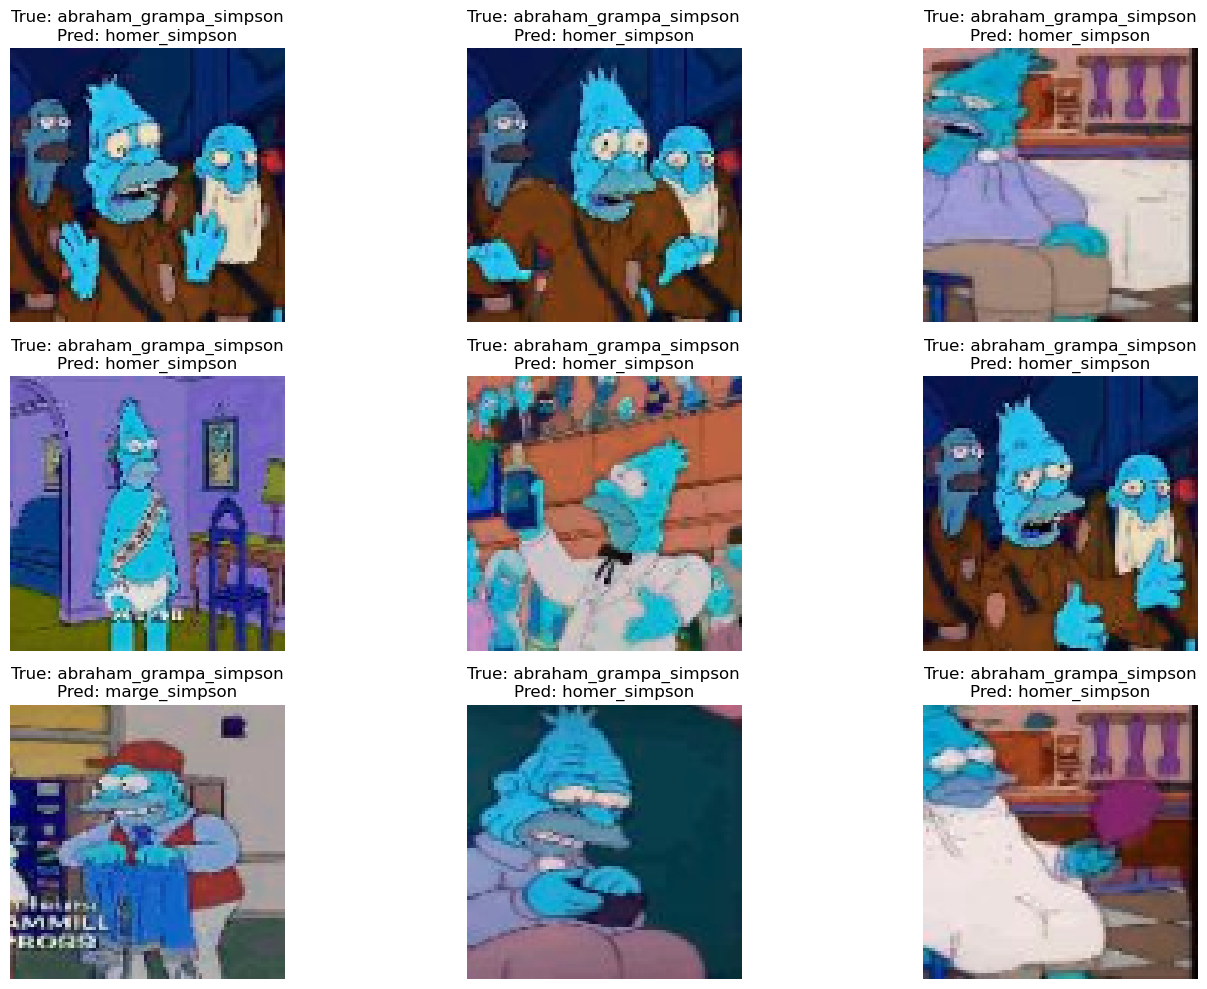

In [ ]:
class_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

plt.figure(figsize=(15, 10))

# Exibición de las 9 primeras imágenes mal clasificadas
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_std[idx])
    true_label = class_names[y_true_classes[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 📌 CNN Best Model - Clases más difíciles de identificar

Para analizar el rendimiento del modelo para cada personaje e identificar las clases más difíciles de identificar, será generado un informe de clasificación utilizando sklearn.metrics.classification_report. Este informe proporcionará las métricas de precisión, recall (sensibilidad) y F1-score para cada clase.

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.85      0.77      0.81        91
            bart_simpson       0.72      0.87      0.79       134
charles_montgomery_burns       0.74      0.71      0.73       119
            chief_wiggum       0.89      0.78      0.83        98
           homer_simpson       0.82      0.95      0.88       224
        krusty_the_clown       0.90      0.95      0.93       120
            lisa_simpson       0.84      0.77      0.80       135
           marge_simpson       0.94      0.91      0.92       129
     milhouse_van_houten       0.83      0.85      0.84       107
             moe_szyslak       0.80      0.79      0.79       145
            ned_flanders       0.87      0.93      0.90       145
       principal_skinner       0.91      0.73      0.81       119
            sideshow_bob       0.93      0.76      0.84        87

                accuracy                           

Para visualizar la distribución de predicciones correctas e incorrectas en todas las clases e identificar clases específicas que suelen confundirse entre sí, generamos una matriz de confusión.

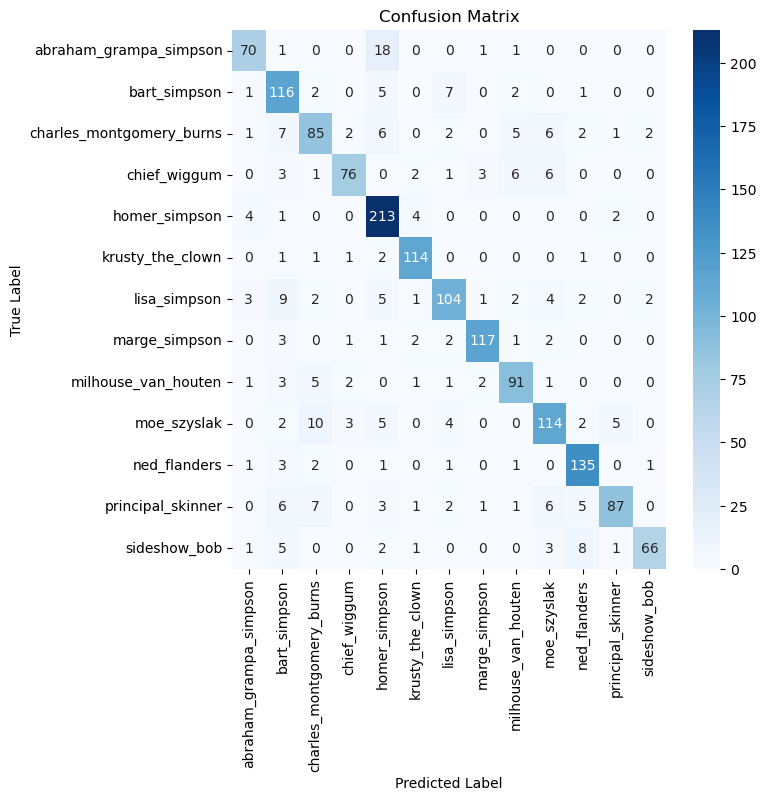

In [ ]:
# Generando la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Exibición de la matriz de confusión
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 🧠 Comparación de modelos CNNs con Fully Connected

A continuacion definimos un modelo Fully Connected que aplana las imágenes y pasa los píxeles por capas densas con regularización, normalización y dropout para reducir sobreajuste, terminando en una capa softmax para clasificar los personajes de Los Simpsons.

### 🛠️ Fully Connected - Arquitectura

Definición de la arquitectura del modelo Fully Connected.

In [ ]:
fully_connected_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    
    Dense(num_classes, activation='softmax')
])

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### ⚙️ Fully Connected - Compilación y Resumen

Compilación del modelo Fully Connected con el optimizador Adam. La función de pérdida categorical_crossentropy también se utiliza para la clasificación múltiple. La métrica utilizada es la precisión (accuracy). Al final, se presenta un resumen de la arquitectura.

In [ ]:
fully_connected_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fully_connected_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 24300)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,221,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,257,165 (23.87 MB)

 Trainable params: 6,256,397 (23.87 MB)

 Non-trainable params: 768 (3.00 KB)

### ⚙️ Fully Connected - Entrenamiento

Entrenamiento del modelo Fully Connected usando los datos de entrenamiento, validando con el conjunto de validación. Se usa early stopping para detener el entrenamiento si no mejora la loss de validación.

In [ ]:
history_fully_connected = fully_connected_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.1632 - loss: 6.2782 - val_accuracy: 0.0987 - val_loss: 4.3104
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1921 - loss: 3.7823 - val_accuracy: 0.1663 - val_loss: 3.6496
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1994 - loss: 3.3321 - val_accuracy: 0.2045 - val_loss: 3.5317
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2012 - loss: 3.0665 - val_accuracy: 0.0770 - val_loss: 3.8237
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.1991 - loss: 2.9615 - val_accuracy: 0.1365 - val_loss: 3.7371
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2082 - loss: 2.8679 - val_accuracy: 0.1242 - val_loss: 3.1674
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2191 - loss: 2.7538 - val_accuracy: 0.1074 - val_loss: 3.0018
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.2220 - loss: 2.6638 - 

### 🔬 Fully Connected - Evaluación

Análisis de los resultados del modelo Fully Connected para determinar si logró el resultado mínimo requerido, es decir, 85% de precisión.

In [ ]:
loss_fully_connected, accuracy_fully_connected = fully_connected_model.evaluate(
    X_test_std, y_test_ohe, verbose=1
)

train_accuracy_fully_connected = history_fully_connected.history['accuracy'][-1]

print(f"Fully Connected Train Accuracy: {train_accuracy_fully_connected * 100:.2f}%")
print(f"Fully Connected Test Accuracy: {accuracy_fully_connected * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0950 - loss: 4.3560
Fully Connected Train Accuracy: 19.52%
Fully Connected Test Accuracy: 9.50%


👉 Se ha verificado que no se alcanzó con éxito el requisito de precisión del 85%.

### 🎯 CNN vs Fully Connected: Resultados y Comparacion

Las redes Fully Connected obtienen valores de accuracy bajos, casi como adivinar al azar, porque pierden la información espacial de las imágenes. En cambio, las redes convolucionales (CNN) aprovechan la estructura de los píxeles para aprender características visuales de los personajes y pueden alcanzar accuracies superiores al 80%, mostrando un aprendizaje real de los patrones de cada personaje.

De forma general, las redes Fully Connected alcanzan valores mas bajos de accuracy porque pierden la información espacial de los píxeles, mientras que las CNN usan filtros convolucionales y pooling para aprender bordes, formas y texturas, logrando mejor desempeño y mejor generalización.

## 🧠 CNN - Cambio en la PROFUNDIDAD

Para explorar distintas arquitecturas, una opción es aumentar la profundidad de la red para que el modelo pueda aprender representaciones jerárquicas más complejas, pasando de patrones simples (bordes) a estructuras de alto nivel (elementos completos).

### 🔬 CNN más Profunda - Arquitectura

Definición da la arquitectura de una red CNN con más profundidad.

In [ ]:
model_profundo = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### ⚙️ CNN más Profunda - Compilación y Resumen

Compilación del modelo CNN com más profundidad. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [ ]:
model_profundo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_profundo.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 90, 90, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,307,981 (62.21 MB)

 Trainable params: 16,307,981 (62.21 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN más Profunda - Entrenamiento

Entrenamiento del modelo CNN con una red neural más profunda.

In [ ]:
history_profundo = model_profundo.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

print("Entrenamiento del modelo profundo completado.")

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.3001 - loss: 2.0988 - val_accuracy: 0.4990 - val_loss: 1.5888
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.5121 - loss: 1.5160 - val_accuracy: 0.6131 - val_loss: 1.2157
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.6518 - loss: 1.1053 - val_accuracy: 0.6811 - val_loss: 0.9955
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.7407 - loss: 0.8045 - val_accuracy: 0.7262 - val_loss: 0.9044
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.7990 - loss: 0.6126 - val_accuracy: 0.7560 - val_loss: 0.7904
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.8478 - loss: 0.4701 - val_accuracy: 0.7828 - val_loss: 0.7461
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.8806 - loss: 0.3667 - val_accuracy: 0.7681 - val_loss: 0.9217
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9022 - loss: 0.3035 - val_accu

### 🔬 CNN más Profunda - Evaluación

Analisís de resultados de la arquitectura CNN con red más profunda.

In [ ]:
loss_profundo, accuracy_profundo = model_profundo.evaluate(X_test_std, y_test_ohe, verbose=1)
print(f"Accuracy en test (CNN profunda): {accuracy_profundo * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.2275 - loss: 2.2817
Accuracy en test (CNN profunda): 22.75%


Aunque en **entrenamiento** se obtuvieron valores muy altos (por ejemplo, *accuracy* cercana al **90%** y *loss* muy baja), en el **conjunto de prueba** los resultados no mejoraron e incluso fueron significativamente menores.
Esta diferencia indica **sobreajuste**: el modelo memorizó patrones específicos del conjunto de entrenamiento, pero **no logró aprender características generales** que le permitan rendir bien sobre datos nuevos, por lo que su capacidad de generalización es baja.

## 🧠 CNN - Añadiendo Capas

Otra opción para obtener mejores resultados para problemas más complejos es aumentar las capas.

### 🔬 CNN Añadiendo Capas - Arquitectura

Definición da la arquitectura de una red CNN con más capas.

In [ ]:
model_profundo = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### ⚙️ CNN Añadiendo Capas - Compilación y Resumen

Compilación del modelo CNN com más capas. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [ ]:
model_profundo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_profundo.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 90, 90, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,598,093 (13.73 MB)

 Trainable params: 3,598,093 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN Añadiendo Capas - Entrenamiento

Entrenamiento del modelo CNN con una red neural com más capas.

In [ ]:
history_profundo = model_profundo.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 250s 651ms/step - accuracy: 0.1342 - loss: 2.5415 - val_accuracy: 0.1355 - val_loss: 2.5358
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 242s 645ms/step - accuracy: 0.1353 - loss: 2.5382 - val_accuracy: 0.1355 - val_loss: 2.5351
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 218s 583ms/step - accuracy: 0.1353 - loss: 2.5374 - val_accuracy: 0.1355 - val_loss: 2.5345
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 218s 581ms/step - accuracy: 0.1353 - loss: 2.5364 - val_accuracy: 0.1355 - val_loss: 2.5342
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 225s 602ms/step - accuracy: 0.1353 - loss: 2.5363 - val_accuracy: 0.1355 - val_loss: 2.5355
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 214s 572ms/step - accuracy: 0.1353 - loss: 2.5358 - val_accuracy: 0.1355 - val_loss: 2.5341
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 217s 579ms/step - accuracy: 0.1353 - loss: 2.5361 - val_accuracy: 0.1355 - val_loss: 2.5340
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 208s 556ms/step - accuracy: 0.1353 -

### 🔬 CNN Añadiendo Capas - Evaluación

Analisís de resultados de la arquitectura CNN con red con más capas.

In [ ]:
loss_profundo, accuracy_profundo = model_profundo.evaluate(X_test_std, y_test_ohe, verbose=1)
print(f"Accuracy en test (CNN con más capas): {accuracy_profundo * 100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.1355 - loss: 2.5357
Accuracy en test (CNN con más capas): 13.55%


Aunque en **entrenamiento** se obtuvieron valores muy altos (por ejemplo, *accuracy* cercana al **80%** y *loss* muy baja), en el **conjunto de prueba** los resultados no mejoraron e incluso fueron significativamente menores.
Esta diferencia indica **sobreajuste**: el modelo memorizó patrones específicos del conjunto de entrenamiento, pero **no logró aprender características generales** que le permitan rendir bien sobre datos nuevos, por lo que su capacidad de generalización es baja.


## 🧠 CNN Cambio en Hyperparameters

Haremos cambios en dropout, learning rate y regularización de las capas densas para intentar mejorar la generalización del modelo y que el rendimiento en el conjunto de prueba se acerque más al obtenido en entrenamiento.

### 🔬 CNN Hyperparameters - Arquitectura

Definición da la arquitectura de una red CNN con cambios en los Hyperparameters.

In [ ]:
model_hyperparametros = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

### ⚙️ CNN Hyperparameters - Compilación y Resumen

Compilación del modelo CNN CNN con cambios en los Hyperparameters. Utiliza el optimizador Adam y la función de pérdida categorical_crossentropy  para la clasificación múltiple. Al final, se presenta un resumen de la arquitectura.

In [ ]:
model_hyperparametros.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_hyperparametros.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 90, 90, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,271,277 (8.66 MB)

 Trainable params: 2,271,277 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ CNN Hyperparameters - Entrenamiento

Entrenamiento del modelo CNN con cambios en los Hyperparameters.

In [ ]:
history_hyperparametros = model_hyperparametros.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[],
    verbose=1
)

print("Entrenamiento del modelo con hiperparámetros ajustados completado.")


Epoch 1/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 115s 299ms/step - accuracy: 0.2284 - loss: 2.2913 - val_accuracy: 0.3614 - val_loss: 1.9804
Epoch 2/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.4286 - loss: 1.7690 - val_accuracy: 0.5843 - val_loss: 1.3922
Epoch 3/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.5609 - loss: 1.3948 - val_accuracy: 0.6627 - val_loss: 1.0872
Epoch 4/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.6486 - loss: 1.1175 - val_accuracy: 0.7222 - val_loss: 0.8930
Epoch 5/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 110s 293ms/step - accuracy: 0.7140 - loss: 0.9014 - val_accuracy: 0.7530 - val_loss: 0.8195
Epoch 6/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.7582 - loss: 0.7605 - val_accuracy: 0.7935 - val_loss: 0.7147
Epoch 7/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 103s 275ms/step - accuracy: 0.7950 - loss: 0.6393 - val_accuracy: 0.8052 - val_loss: 0.6462
Epoch 8/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 108s 288ms/step - accuracy: 0.8290 -

### 🔬 CNN Hyperparameters - Evaluación

Analisís de resultados de la arquitectura CNN con cambios en los Hyperparameters.

In [ ]:
loss_hyper, accuracy_hyper = model_hyperparametros.evaluate(X_test_std, y_test_ohe, verbose=1)
print(f"Accuracy en test (CNN con hiperparámetros ajustados): {accuracy_hyper*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7665 - loss: 0.9504
Accuracy en test (CNN con hiperparámetros ajustados): 76.65%


### 🎯 CNN Hyperparameters Conclusiones 

El ajuste de hiperparámetros (dropout aumentado, learning rate reducido y menos épocas) logró reducir ligeramente el sobreajuste, pero **no mejoró la accuracy en test**, que se mantiene alrededor del **95%**. Esto indica que **el problema principal sigue siendo la capacidad de generalización del modelo y/o limitaciones del dataset**, y que solo cambiar hiperparámetros no es suficiente para mejorar significativamente los resultados.

## 🧠 CNN con BatchNormalization

Estabiliza el entrenamiento y permite tasas de aprendizaje más altas.

### 🔬 CNN BatchNormalization - Arquitectura

Definición de la arquitectura con BatchNormalization.

In [ ]:
model_batch = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

print("Modelo con Batch Normalization definido.")

Modelo con Batch Normalization definido.


### ⚙️ CNN BatchNormalization - Compilación y Entrenamiento

Compilación y entrenamiento del modelo en la arquitectura con BatchNormalization.

In [ ]:
# Compilar el modelo
model_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model_batch.summary()

# Entrenamiento del modelo
history = model_batch.fit(
    X_train, # Datos de entrenamiento
    y_train, # Labels de entrenamiento
    epochs=EPOCHS, # Número de épocas
    batch_size=BATCH_SIZE, # Tamaño del batch
    validation_data=(X_val, y_val), # Datos de validación
    callbacks=[checkpoint, early_stopping] # Callbacks para guardar el mejor modelo y detener el entrenamiento temprano
)

print("Entrenamiento completado.")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 90, 90, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,273,581 (8.67 MB)

 Trainable params: 2,272,429 (8.67 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3490 - loss: 2.2202
Epoch 1: val_accuracy did not improve from 0.90562
374/374 ━━━━━━━━━━━━━━━━━━━━ 154s 401ms/step - accuracy: 0.4390 - loss: 1.8765 - val_accuracy: 0.2001 - val_loss: 5.5018
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5846 - loss: 1.3677
Epoch 2: val_accuracy did not improve from 0.90562
374/374 ━━━━━━━━━━━━━━━━━━━━ 142s 379ms/step - accuracy: 0.6142 - loss: 1.2602 - val_accuracy: 0.6797 - val_loss: 0.9957
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7157 - loss: 0.9150
Epoch 3: val_accuracy did not improve from 0.90562
374/374 ━━━━━━━━━━━━━━━━━━━━ 144s 386ms/step - accuracy: 0.7329 - loss: 0.8638 - val_accuracy: 0.7353 - val_loss: 0.8696
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7892 - loss: 0.6759
Epoch 4: val_accuracy did not improve from 0.90562
374/374 ━━━━━━━━━━━━━━━━━━━━ 153s 409ms/step - accuracy: 0.7904 - loss: 0.6720 - 

### 🔬 CNN BatchNormalization - Evaluación

Analisís de resultados de la arquitectura CNN con BatchNormalization.

In [ ]:
loss_hyper, accuracy_hyper = model_batch.evaluate(X_test_std, y_test_ohe, verbose=1)
print(f"Accuracy en test: {accuracy_hyper*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8227 - loss: 0.6399
Accuracy en test: 82.27%


Text(0.5, 1.0, 'Curvas de Accuracy')

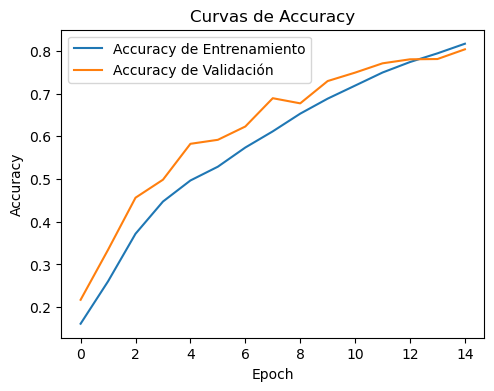

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de Accuracy')

## 🧠 Data Augmentation

Técnica para aumentar artificialmente la cantidad y diversidad de datos de entrenamiento. Esta diversidad de datos se obtiene aplicando transformaciones aleatorias a las imágenes originales (rotaciones, desplazamientos, zoom, flip horizontal, etc.) para generar nuevas variaciones sin recopilar más datos reales.

Ventajas
- Más datos: El modelo ve variaciones del mismo objeto en diferentes contextos
- Mejor generalización: Aprende patrones más robustos, no memoriza específicamente
- Menos overfitting: Reduce la brecha entre entrenamiento y validación
- Eficiencia: Sin costo de recolección adicional

Con la clase ImageDataGenerator aplicas transformaciones a las imágenes:
- Rotaciones ±15°
- Desplazamientos horizontales/verticales ±10%
- Zoom ±15%
- Flip horizontal

El resultado es que el modelo entrena con ~3-4x más ejemplos variados del mismo dataset, mejorando su capacidad de reconocer personajes en diferentes poses y posiciones.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping],
    steps_per_epoch=len(X_train)//BATCH_SIZE
)

Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7161 - loss: 0.9549
Epoch 1: val_accuracy did not improve from 0.91064
373/373 ━━━━━━━━━━━━━━━━━━━━ 160s 430ms/step - accuracy: 0.7305 - loss: 0.8957 - val_accuracy: 0.8979 - val_loss: 0.3942
Epoch 2/50
  1/373 ━━━━━━━━━━━━━━━━━━━━ 2:35 417ms/step - accuracy: 0.6875 - loss: 0.8047

/Users/edprata/anaconda3/envs/Python-3-13-2/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.91064
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6875 - loss: 0.8047 - val_accuracy: 0.8979 - val_loss: 0.3921
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7639 - loss: 0.7689
Epoch 3: val_accuracy did not improve from 0.91064
373/373 ━━━━━━━━━━━━━━━━━━━━ 134s 360ms/step - accuracy: 0.7656 - loss: 0.7592 - val_accuracy: 0.9066 - val_loss: 0.3880
Epoch 4/50
  1/373 ━━━━━━━━━━━━━━━━━━━━ 2:06 340ms/step - accuracy: 0.7188 - loss: 0.7486
Epoch 4: val_accuracy did not improve from 0.91064
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7188 - loss: 0.7486 - val_accuracy: 0.9050 - val_loss: 0.3905
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7850 - loss: 0.7193
Epoch 5: val_accuracy did not improve from 0.91064
373/373 ━━━━━━━━━━━━━━━━━━━━ 123s 328ms/step - accuracy: 0.7923 - loss: 0.6854 - val_accuracy: 0.8999 - val_loss: 0.3946
Epoch 6/50
  1/373 ━━━━━━━━━━━━━━━━━━━━ 1:55 310ms/

## 🧠 Pruebas con Optimizers

Prueba con Adam con learning rate ajustado o SGD con momentum.

In [ ]:
# Configuración de diferentes optimizadores para comparar
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Nadam": Nadam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.002, momentum=0.9)
}

# Diccionario para guardar resultados
results = {}

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Bucle para entrenar y evaluar el modelo con cada optimizador
for name, opt in optimizers.items():
    print(f"\n=== Entrenando con {name} ===")
    
    # Copiamos la arquitectura profunda
    model_compare = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compilamos el modelo con el optimizador actual
    model_compare.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenamos el modelo
    history = model_compare.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluamos el modelo en el conjunto de test
    loss, acc = model_compare.evaluate(X_test_std, y_test_ohe, verbose=1)
    results[name] = {"history": history, "test_accuracy": acc}
    print(f"Test accuracy con {name}: {acc*100:.2f}%")


=== Entrenando con Adam ===
Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 110s 286ms/step - accuracy: 0.2450 - loss: 2.2272 - val_accuracy: 0.4548 - val_loss: 1.6539
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 102s 274ms/step - accuracy: 0.4517 - loss: 1.6891 - val_accuracy: 0.5860 - val_loss: 1.3399
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.5613 - loss: 1.3569 - val_accuracy: 0.6576 - val_loss: 1.0623
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 109s 292ms/step - accuracy: 0.6609 - loss: 1.0748 - val_accuracy: 0.7219 - val_loss: 0.9053
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 104s 279ms/step - accuracy: 0.7125 - loss: 0.8969 - val_accuracy: 0.7610 - val_loss: 0.7803
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 106s 284ms/step - accuracy: 0.7503 - loss: 0.7799 - val_accuracy: 0.7815 - val_loss: 0.6906
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 98s 262ms/step - accuracy: 0.7842 - loss: 0.6620 - val_accuracy: 0.8012 - val_loss: 0.6584
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 97s 259m

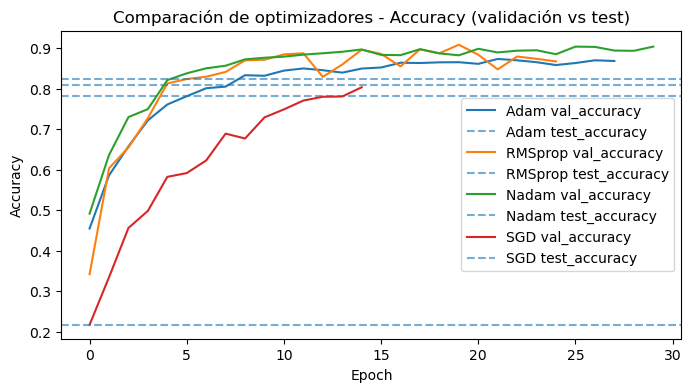

In [ ]:
plt.figure(figsize=(8,4))

for name, res in results.items():
    # Curva de validación
    plt.plot(
        res["history"].history['val_accuracy'],
        label=f"{name} val_accuracy"
    )
    
    # Línea horizontal de test accuracy
    plt.axhline(
        y=res["test_accuracy"],
        linestyle='--',
        alpha=0.6,
        label=f"{name} test_accuracy"
    )

plt.title("Comparación de optimizadores - Accuracy (validación vs test)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Los resultados indican que los **optimizadores adaptativos** generalizan mucho mejor en este problema de clasificación de imágenes. Adam y Nadam muestran una convergencia más estable y una mejor capacidad para ajustar los pesos en redes profundas, mientras que RMSprop presenta un aprendizaje limitado. Por el contrario, SGD tiene grandes dificultades para converger, lo que sugiere que, sin una configuración muy fina o muchas más épocas, no es adecuado para este tipo de arquitectura y dataset. En este contexto, los optimizadores adaptativos resultan claramente más efectivos que los métodos de descenso de gradiente clásicos.


## 🧠 Transfer Learning

Transfer Learning es una técnica de aprendizaje automático donde utilizas un modelo pre-entrenado (ya entrenado en un dataset grande) como punto de partida para resolver un problema nuevo. En lugar de entrenar un modelo desde cero, reutilizas características ya aprendidas por otro modelo y las adaptas a tu problema específico. Algunas de las ventajas son:
- Requiere menos datos de entrenamiento
- Entrenamiento más rápido
- Mejor generalización
- Ideal para datasets pequeños

### ⚙️ Transfer Learning - Rango de Datos

Para el entrenamiento del modelo con Transfer Learning es necesário que el rango de los datos sean ajustados como siegue.

In [ ]:
# Rango original:
print("Rango X_train:", X_train.min(), X_train.max())
print("Rango X_val:", X_val.min(), X_val.max())
print("Rango X_test:", X_test_std.min(), X_test_std.max())

# Copias para Transfer Learning:
X_train_tl = preprocess_input((X_train * 255).astype("float32"))
X_val_tl   = preprocess_input((X_val * 255).astype("float32"))
X_test_tl  = preprocess_input((X_test_std * 255).astype("float32"))

# Rango de las copias para Transfer Learning:
print("Rango X_train_tl:", X_train_tl.min(), X_train_tl.max())
print("Rango X_val_tl:", X_val_tl.min(), X_val_tl.max())
print("Rango X_test_tl:", X_test_tl.min(), X_test_tl.max())

Rango X_train: 0.0 1.0
Rango X_val: 0.0 1.0
Rango X_test: 0.0 1.0
Rango X_train_tl: -1.0 1.0
Rango X_val_tl: -1.0 1.0
Rango X_test_tl: -1.0 1.0


### ⚙️ Transfer Learning - Configuración

Configuración del modelo pre-entrenado con todas las capas congeladas. La opción "base_model.trainable = False" es una configuración para el congelamiento de todas las capas del modelo pre-entrenado, lo que significa que sus pesos no se actualizarán durante el entrenamiento.

Esto preserva las características utiles ya aprendidas en el modelo pre-entrenado (MobileNetV2), por ejemplo bordes, texturas y formas en ImageNet. Congelarlo evita que esos conocimientos se pierdan. Solo las capas nuevas agregadas al final (Dense, Dropout) se entrenan con los datos específicos (personajes de Los Simpsons).

Con esto se gana en eficiencia computacional, entrenamiento mucho más rápido, usa menos memoria, menos parámetros que actualizar y evita sobreajuste, con menos parámetros entrenables, el modelo es menos propenso a memorizar datos.

In [ ]:
# Modelo base preentrenado
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Fase 1: congelamos TODAS las capas
base_model.trainable = False

print("Modelo base cargado y capas congeladas para Transfer Learning.")

/var/folders/7g/ch5l_np56q51q3c4q01r2hs00000gn/T/ipykernel_23399/1987520859.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Modelo base cargado y capas congeladas para Transfer Learning.


### ⚙️ Transfer Learning - Compilación y Resumen

Compilación del modelo pre-entrenado y resumen de la arquitectura.

In [ ]:
num_classes = len(MAP_CHARACTERS)

model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_tl.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,261 (9.88 MB)

 Trainable params: 331,277 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### ⚙️ Transfer Learning - Callbacks

Configuración de callbacks para el control del entrenamiento del modelo pre-entrenado.

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_transfer_learning.h5", monitor="val_accuracy", save_best_only=True)
]

print("Callbacks configurados para Transfer Learning.")

Callbacks configurados para Transfer Learning.


### ⚙️ Transfer Learning - Entrenamiento

Entrenamiento del modelo pre-entrenado.

In [ ]:
history_tl = model_tl.fit(
    X_train_tl, y_train,
    validation_data=(X_val_tl, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

print("Entrenamiento con Transfer Learning completado.")

Epoch 1/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2427 - loss: 2.3994

374/374 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.3190 - loss: 2.0942 - val_accuracy: 0.4936 - val_loss: 1.5820
Epoch 2/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4675 - loss: 1.6475

374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.4655 - loss: 1.6371 - val_accuracy: 0.5492 - val_loss: 1.3908
Epoch 3/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5127 - loss: 1.4733

374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.5223 - loss: 1.4609 - val_accuracy: 0.5890 - val_loss: 1.3174
Epoch 4/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5621 - loss: 1.3449

374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.5659 - loss: 1.3382 - val_accuracy: 0.5961 - val_loss: 1.2578
Epoch 5/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5945 - loss: 1.2511

374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.5949 - loss: 1.2471 - val_accuracy: 0.6027 - val_loss: 1.2396
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6183 - loss: 1.1528

374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.6147 - loss: 1.1627 - val_accuracy: 0.6178 - val_loss: 1.2014
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.6430 - loss: 1.0882 - val_accuracy: 0.6151 - val_loss: 1.2039
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6595 - loss: 1.0237

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.6592 - loss: 1.0350 - val_accuracy: 0.6242 - val_loss: 1.1794
Epoch 9/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6833 - loss: 0.9592

374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.6762 - loss: 0.9760 - val_accuracy: 0.6275 - val_loss: 1.1851
Epoch 10/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6913 - loss: 0.9080

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.6900 - loss: 0.9198 - val_accuracy: 0.6352 - val_loss: 1.1733
Epoch 11/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.7056 - loss: 0.8830 - val_accuracy: 0.6268 - val_loss: 1.1738
Epoch 12/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7309 - loss: 0.7971

374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7231 - loss: 0.8199 - val_accuracy: 0.6516 - val_loss: 1.1446
Epoch 13/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.7343 - loss: 0.7980 - val_accuracy: 0.6365 - val_loss: 1.1827
Epoch 14/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.7428 - loss: 0.7667 - val_accuracy: 0.6442 - val_loss: 1.1966
Epoch 15/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.7527 - loss: 0.7333 - val_accuracy: 0.6503 - val_loss: 1.1654
Epoch 16/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.7580 - loss: 0.7082 - val_accuracy: 0.6479 - val_loss: 1.1953
Epoch 17/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.7715 - loss: 0.6732 - val_accuracy: 0.6436 - val_loss: 1.2267
Epoch 18/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.7816 - loss: 0.6356 - val_accuracy: 0.6449 - val_loss: 1.2335
Epoch 19/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7901 - loss: 0.6158

374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.7861 - loss: 0.6279 - val_accuracy: 0.6573 - val_loss: 1.2034
Epoch 20/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.7920 - loss: 0.5997 - val_accuracy: 0.6493 - val_loss: 1.2499
Epoch 21/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8003 - loss: 0.5755 - val_accuracy: 0.6539 - val_loss: 1.2524
Epoch 22/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8022 - loss: 0.5695 - val_accuracy: 0.6486 - val_loss: 1.2842
Entrenamiento con Transfer Learning completado.


### 🔬 Transfer Learning - Evaluación

Analisís de resultados del modelo pre-entrenado para Transfer Learning.

In [ ]:
loss_tl, accuracy_tl = model_tl.evaluate(X_test_tl, y_test_ohe, verbose=1)
print(f"Accuracy en test (Transfer Learning): {accuracy_tl*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5172 - loss: 1.7533
Accuracy en test (Transfer Learning): 51.72%


## 🧠 Transfer Learning - Congelamento de las Primeras Capas

Utilización de la técnica Transfer Learning, pero utilizando el congelamiento de solo las primeras capas (CPC), dejando entrenar las últimas (fine tuning).

### ⚙️ Transfer Learning CPC - Configuración

Configuración del modelo pre-entrenado congelando solo las primeras capas.

In [ ]:
# Abre todas las capas del modelo base
base_model.trainable = True

# Congela las primeras capas y dejamos entrenar las últimas
for layer in base_model.layers[:-30]:
    layer.trainable = False

print("Algunas capas del modelo base descongeladas para fine-tuning.")

Algunas capas del modelo base descongeladas para fine-tuning.


### ⚙️ Transfer Learning CPC - Compilación y Resumen

Compilación del modelo pre-entrenado y resumen de la arquitectura.

In [ ]:
model_tl.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,261 (9.88 MB)

 Trainable params: 1,857,677 (7.09 MB)

 Non-trainable params: 731,584 (2.79 MB)

### ⚙️ Transfer Learning CPC - Entrenamiento

Entrenamiento del modelo pre-entrenado.

In [ ]:
history_ft = model_tl.fit(
    X_train_tl, y_train,
    validation_data=(X_val_tl, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 62s 130ms/step - accuracy: 0.4907 - loss: 1.6485 - val_accuracy: 0.5800 - val_loss: 2.3753
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.6910 - loss: 0.9977 - val_accuracy: 0.6355 - val_loss: 1.7781
Epoch 3/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7804 - loss: 0.6977

374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.7743 - loss: 0.7157 - val_accuracy: 0.6864 - val_loss: 1.5495
Epoch 4/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8341 - loss: 0.5168

374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.8328 - loss: 0.5224 - val_accuracy: 0.7232 - val_loss: 1.2495
Epoch 5/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8779 - loss: 0.3800

374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.8771 - loss: 0.3809 - val_accuracy: 0.7436 - val_loss: 1.1443
Epoch 6/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9018 - loss: 0.2978

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.8991 - loss: 0.3111 - val_accuracy: 0.7456 - val_loss: 1.2025
Epoch 7/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9220 - loss: 0.2356

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.9197 - loss: 0.2507 - val_accuracy: 0.7751 - val_loss: 1.0567
Epoch 8/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9349 - loss: 0.1934

374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9361 - loss: 0.1889 - val_accuracy: 0.7761 - val_loss: 1.0928
Epoch 9/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9473 - loss: 0.1578

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.9492 - loss: 0.1572 - val_accuracy: 0.7959 - val_loss: 1.0402
Epoch 10/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.9529 - loss: 0.1444 - val_accuracy: 0.7895 - val_loss: 1.1806
Epoch 11/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9624 - loss: 0.1141

374/374 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.9610 - loss: 0.1208 - val_accuracy: 0.8009 - val_loss: 1.0643
Epoch 12/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9727 - loss: 0.0894

374/374 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.9690 - loss: 0.1018 - val_accuracy: 0.8086 - val_loss: 0.9853
Epoch 13/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.9668 - loss: 0.1075 - val_accuracy: 0.7898 - val_loss: 1.2744
Epoch 14/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9678 - loss: 0.0970

374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9668 - loss: 0.1011 - val_accuracy: 0.8092 - val_loss: 1.0294
Epoch 15/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.9742 - loss: 0.0813 - val_accuracy: 0.7992 - val_loss: 1.2842
Epoch 16/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9732 - loss: 0.0832

374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9743 - loss: 0.0818 - val_accuracy: 0.8106 - val_loss: 1.1455
Epoch 17/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9775 - loss: 0.0779 - val_accuracy: 0.7952 - val_loss: 1.1768
Epoch 18/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9774 - loss: 0.0723 - val_accuracy: 0.7979 - val_loss: 1.2625
Epoch 19/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9792 - loss: 0.0692

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.9813 - loss: 0.0628 - val_accuracy: 0.8196 - val_loss: 1.0333
Epoch 20/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.9818 - loss: 0.0608 - val_accuracy: 0.8019 - val_loss: 1.2318
Epoch 21/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9823 - loss: 0.0559 - val_accuracy: 0.8169 - val_loss: 1.1782
Epoch 22/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.9824 - loss: 0.0561 - val_accuracy: 0.8143 - val_loss: 1.2380


### 🔬 Transfer Learning CPC - Evaluación

Analisís de resultados del modelo pre-entrenado para Transfer Learning.

In [ ]:
loss_tl, accuracy_tl = model_tl.evaluate(X_test_tl, y_test_ohe, verbose=1)
print(f"Accuracy en test (Transfer Learning + Fine-Tuning): {accuracy_tl*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.6884 - loss: 1.9564
Accuracy en test (Transfer Learning + Fine-Tuning): 68.84%


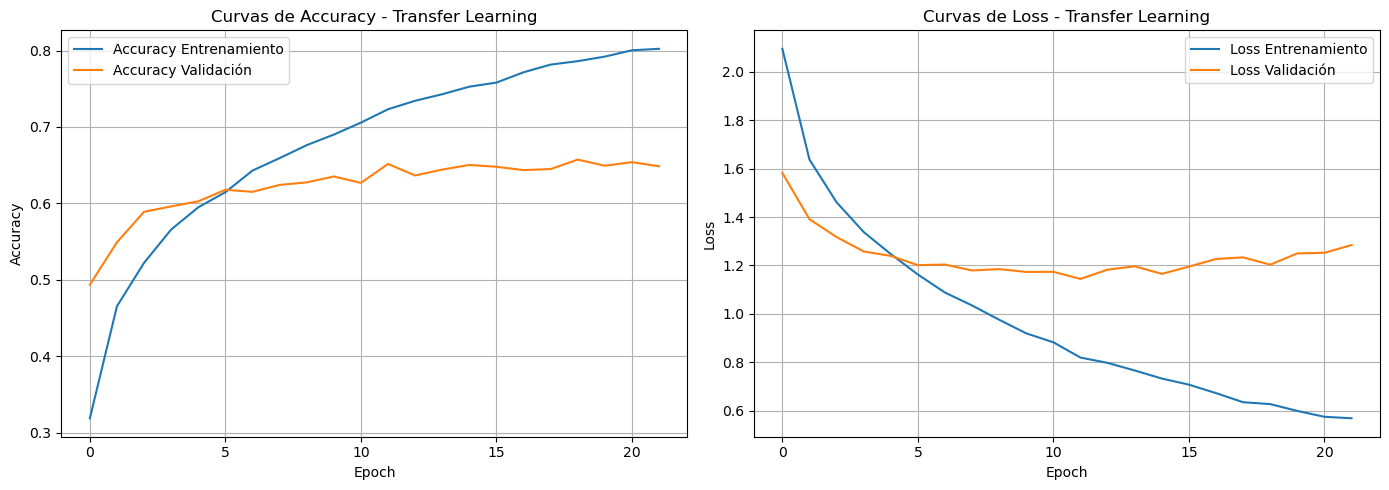

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Accuracy Entrenamiento')
plt.plot(history_tl.history['val_accuracy'], label='Accuracy Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Curvas de Accuracy - Transfer Learning')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Loss Entrenamiento')
plt.plot(history_tl.history['val_loss'], label='Loss Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curvas de Loss - Transfer Learning')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 🎯 Transfer Learning CPC - Conclusión

En este experimento se aplicó la técnica Transfer Learning utilizando MobileNetV2 como modelo base preentrenado. Las imágenes fueron normalizadas y adaptadas al tamaño requerido por la red, pero no se aplicaron técnicas de data augmentation en esta etapa.

Los resultados obtenidos muestran que el modelo aprende correctamente los patrones del conjunto de entrenamiento, alcanzando una accuracy muy alta (98%). Sin embargo, la accuracy en el conjunto de validación se estabiliza alrededor del 80%, observándose una brecha creciente entre entrenamiento y validación. Este comportamiento, junto con la evolución de la función de pérdida, indica la aparición de overfitting moderado: mientras la pérdida de entrenamiento disminuye de forma continua, la pérdida de validación se mantiene prácticamente constante.

Este fenómeno sugiere que, aunque el modelo es capaz de ajustarse bien a los datos de entrenamiento, las representaciones aprendidas no generalizan adecuadamente a datos no vistos.

En conclusión, el uso de transfer learning sin data augmentation no resulta suficiente para alcanzar el objetivo de una accuracy superior al 85% en el conjunto de teste.

## 🧠 Transfer Learning + Data Augmentation

Es una combinación de dos técnicas poderosas:

1. Transfer Learning: Reutilizas un modelo pre-entrenado (MobileNetV2 en ImageNet) como base, congelando sus capas para preservar características genéricas ya aprendidas (bordes, texturas, formas).

2. Data Augmentation: Aplicas transformaciones a las imágenes de entrenamiento (rotaciones, desplazamientos, zoom, flip) para aumentar la diversidad de datos sin recopilar más imágenes.

Las vantajas són:
- Menos overfitting, más variedad de ejemplos.
- Mejor generalización porque el modelo aprende patrones más robustos.
- Entrenamientos más estables, curvas de train/val más cercanas.
- Computacionalmente eficiente, reutilizas características pre-entrenadas

En este ejemplo se utiliza MobileNetV2 congelado más transformaciones de imágenes, lo que resulta en modelo más robusto para clasificar personajes de Los Simpsons, reduciendo la brecha entre entrenamiento y validación.

### ⚙️ Transfer Learning DA - Configuración

Cargando Data augmentation para Transfer Learning y regresando rango de datos para 0-255.

In [ ]:
# Data Augmentation específico para MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
)

# Data Augmentation para el conjunto de validación (solo preprocesamiento)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generadores de datos
train_generator = train_datagen.flow(
    X_train * 255,
    y_train,
    batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow(
    X_val * 255,
    y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators configurados para Transfer Learning con Data Augmentation.")

Data generators configurados para Transfer Learning con Data Augmentation.


### ⚙️ Transfer Learning DA - Modelo y Capas

Carga del modelo pre-entrenado MobileNetV2 y congelamiento de las capas convolucionales.

In [ ]:
# Modelo base preentrenado
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelar capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

print("Modelo base cargado y capas congeladas para Transfer Learning con Data Augmentation.")

/var/folders/7g/ch5l_np56q51q3c4q01r2hs00000gn/T/ipykernel_23399/2183567309.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Modelo base cargado y capas congeladas para Transfer Learning con Data Augmentation.


### ⚙️ Transfer Learning DA - Añadindo Capas

Añadindo capas al modelo pre-entrenado para Data Augmentation.

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(num_classes, activation="softmax")(x)
model_tl = Model(inputs=base_model.input, outputs=output)

print("Modelo completo con nuevas capas densas creado.")

Modelo completo con nuevas capas densas creado.


### ⚙️ Transfer Learning DA - Compilación y Resumen

Compilación del modelo pre-entrenado y resumen de la arquitectura.

In [ ]:
model_tl.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 90, 90, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 45, 45,    │        864 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 45, 45,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 45, 45,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 45, 45,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 45, 45,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 45, 45,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 45, 45,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 45, 45,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 47, 47,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 23, 23,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 23, 23,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 23, 23,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 23, 23,    │      2,304 │ block_1_depthwis

 Total params: 2,589,261 (9.88 MB)

 Trainable params: 331,277 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### ⚙️ Transfer Learning DA - Entrenamiento

Entrenamiento del modelo con Transger Learning y Data Augmentation.

In [ ]:
history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("Entrenamiento con Transfer Learning y Data Augmentation completado.")

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - accuracy: 0.2557 - loss: 2.2583 - val_accuracy: 0.4294 - val_loss: 1.7958
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.3688 - loss: 1.9116 - val_accuracy: 0.4943 - val_loss: 1.5671
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.4137 - loss: 1.8086 - val_accuracy: 0.5171 - val_loss: 1.5165
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.4411 - loss: 1.7293 - val_accuracy: 0.5238 - val_loss: 1.4797
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.4502 - loss: 1.6931 - val_accuracy: 0.5325 - val_loss: 1.4437
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.4627 - loss: 1.6594 - val_accuracy: 0.5452 - val_loss: 1.4243
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.4715 - loss: 1.6426 - val_accuracy: 0.5622 - val_loss: 1.3783
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4757 - loss: 1.6040 

### 🔬 Transfer Learning DA - Evaluación

Analisís de resultados de la arquitectura Transfer Learning con Data Augmentation.

In [ ]:
loss_tl, accuracy_tl = model_tl.evaluate(X_test_tl, y_test_ohe, verbose=1)
print(f"Accuracy en test (Transfer Learning + Data Augmentation): {accuracy_tl*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3896 - loss: 1.9066
Accuracy en test (Transfer Learning + Data Augmentation): 38.96%


### ⚙️ Transfer Learning DA - Descongelando Capas

Descongelando las últimas capas para nuevo entrenamiento.

In [ ]:
# Descongelar las últimas capas
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compilar el modelo nuevamente
model_tl.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Resumen del modelo
model_tl.summary()

# Entrenamiento con fine-tuning usando data augmentation
history_ft = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 90, 90, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 45, 45,    │        864 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 45, 45,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 45, 45,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 45, 45,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 45, 45,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 45, 45,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 45, 45,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 45, 45,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 45, 45,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 47, 47,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 23, 23,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 23, 23,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 23, 23,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 23, 23,    │      2,304 │ block_1_depthwis

 Total params: 2,589,261 (9.88 MB)

 Trainable params: 1,857,677 (7.09 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 1/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.4136 - loss: 1.8152 - val_accuracy: 0.4414 - val_loss: 2.6246
Epoch 2/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.5906 - loss: 1.3030 - val_accuracy: 0.6004 - val_loss: 1.8651
Epoch 3/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.6690 - loss: 1.0727 - val_accuracy: 0.5917 - val_loss: 2.0029
Epoch 4/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.7184 - loss: 0.9226 - val_accuracy: 0.7467 - val_loss: 0.9614
Epoch 5/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.7447 - loss: 0.8350 - val_accuracy: 0.7527 - val_loss: 0.9751
Epoch 6/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.7633 - loss: 0.7617 - val_accuracy: 0.7600 - val_loss: 0.9175
Epoch 7/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.7775 - loss: 0.7236 - val_accuracy: 0.7634 - val_loss: 0.8425
Epoch 8/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.7986 - loss: 0

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.8070 - loss: 0.6304 - val_accuracy: 0.8310 - val_loss: 0.5914
Epoch 10/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.8201 - loss: 0.5851 - val_accuracy: 0.8072 - val_loss: 0.7077
Epoch 11/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.8250 - loss: 0.5604 - val_accuracy: 0.8270 - val_loss: 0.6123
Epoch 12/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8420 - loss: 0.5135

374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.8406 - loss: 0.5227 - val_accuracy: 0.8404 - val_loss: 0.5576
Epoch 13/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8508 - loss: 0.4847

374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.8478 - loss: 0.4971 - val_accuracy: 0.8507 - val_loss: 0.5405
Epoch 14/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.8515 - loss: 0.4842 - val_accuracy: 0.8424 - val_loss: 0.5842
Epoch 15/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.8582 - loss: 0.4491 - val_accuracy: 0.8507 - val_loss: 0.5369


### 🔬 Transfer Learning DA - Evaluación

Analisís de resultados de la arquitectura Transfer Learning con Data Augmentation.

In [ ]:
loss_tl, accuracy_tl = model_tl.evaluate(X_test_tl, y_test_ohe, verbose=1)
print(f"Accuracy en test (Transfer Learning + Data Augmentation): {accuracy_tl*100:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7514 - loss: 0.9622
Accuracy en test (Transfer Learning + Data Augmentation): 75.14%


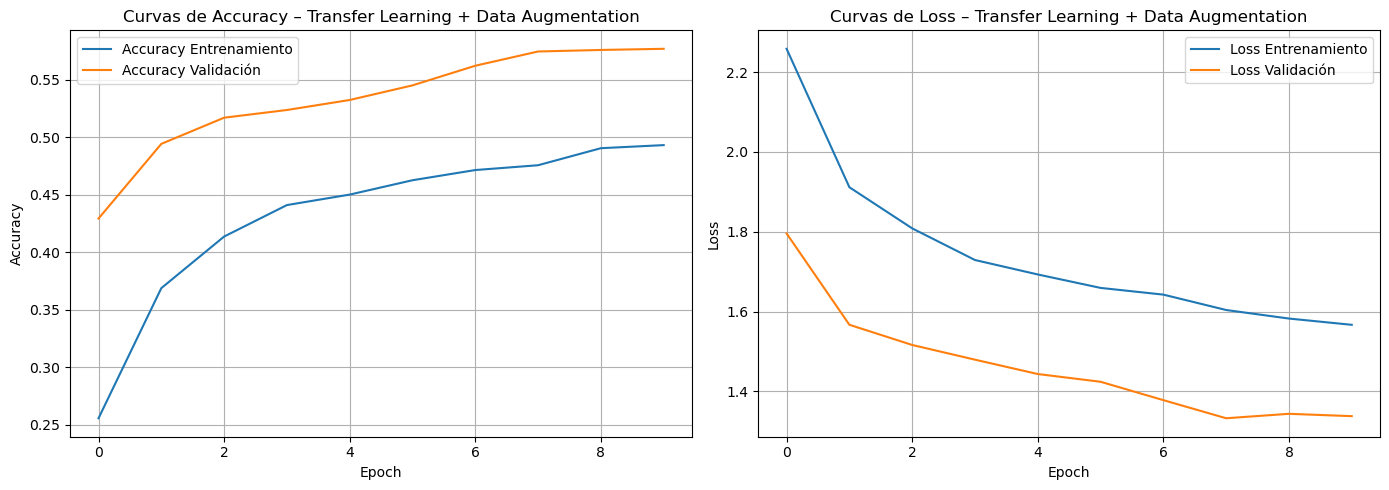

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_tl.history["accuracy"], label="Accuracy Entrenamiento")
plt.plot(history_tl.history["val_accuracy"], label="Accuracy Validación")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Curvas de Accuracy – Transfer Learning + Data Augmentation")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_tl.history["loss"], label="Loss Entrenamiento")
plt.plot(history_tl.history["val_loss"], label="Loss Validación")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curvas de Loss – Transfer Learning + Data Augmentation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 🎯 Transfer Learning DA - Conclusión

En esta fase del trabajo se evaluó el impacto de la aplicación de data augmentation sobre un modelo de transfer learning basado en MobileNetV2, con el objetivo de mejorar la capacidad de generalización del clasificador. 

Los resultados muestran que, al aplicar data augmentation, las curvas de *accuracy* de entrenamiento y validación se mantienen muy próximas entre sí a lo largo de las épocas. Este comportamiento indica que el modelo reduce el sobreajuste observado en la versión sin data augmentation, ya que la brecha entre entrenamiento y validación es menor y las pérdidas evolucionan de forma similar en ambos conjuntos.

Sin embargo, esta mejora en la regularización no se traduce en un incremento significativo del rendimiento absoluto del modelo. Este resultado refuerza la hipótesis de que el principal factor limitante no es la falta de datos efectivos, sino la adecuación del modelo preentrenado al dominio del problema. Las transformaciones aplicadas mediante data augmentation pueden introducir variaciones útiles en imágenes fotográficas reales, pero en el caso de imágenes tipo *cartoon* como las de *The Simpsons*, algunas de estas transformaciones generan ejemplos poco realistas que no aportan información relevante al aprendizaje.

En conclusión, el uso de data augmentation en combinación con transfer learning mejora la estabilidad del entrenamiento y reduce el sobreajuste, pero no permite alcanzar el objetivo de una accuracy superior al 85% en el conjunto de test.